# Unit11_Random_Forest | 隨機森林回歸：催化反應器產率預測

本 Notebook 使用模擬數據建立隨機森林回歸模型來預測催化反應器的產率。

## 學習目標
- 理解隨機森林的集成學習原理與 Bagging 機制
- 使用 `sklearn.ensemble.RandomForestRegressor` 建立模型
- 比較不同樹數量對模型性能的影響
- 使用 GridSearchCV 進行超參數優化
- 分析特徵重要性並量化預測不確定性
- 比較隨機森林與單棵決策樹的性能差異

## 案例背景
**問題**：催化反應器產率預測  
**特徵**：溫度 (150-250°C)、壓力 (1-5 bar)、催化劑用量 (0.5-2.0 g)  
**目標**：產率 (Yield, 70-95%)  
**資料規模**：100 個實驗數據點（訓練集 70 / 測試集 30）

---

---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit11_Random_Forest'
SOURCE_DATA_DIR = 'no_data_folder'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit11'
    DATA_DIR = shortcut_path / 'Part_3' / 'data' / SOURCE_DATA_DIR
    OUTPUT_DIR = shortcut_path / 'outputs' / UNIT_OUTPUT_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
    print(f"✓ Colab 路徑設定完成")
  else:
    raise FileNotFoundError("請確認 Google Drive 中有 'Colab Notebooks/CHE-AI-COURSE' 資料夾")
else:
  NOTEBOOK_DIR = Path.cwd()
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'
  print(f"✓ Local 路徑設定完成")

# 建立輸出資料夾
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n📁 工作目錄: {NOTEBOOK_DIR}")
print(f"📁 輸出目錄: {OUTPUT_DIR}")
print(f"📁 模型目錄: {MODEL_DIR}")
print(f"📁 圖片目錄: {FIG_DIR}")

# ========================================
# GPU 偵測
# ========================================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✓ 偵測到 {len(gpus)} 個 GPU:")
    for gpu in gpus:
        print(f"  - {gpu.name}")
else:
    print("\n✗ 未偵測到 GPU，使用 CPU 運算")

✓ 偵測到 Local 環境
✓ Local 路徑設定完成

📁 工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11
📁 輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Random_Forest
📁 模型目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Random_Forest\models
📁 圖片目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Random_Forest\figs

✓ 偵測到 1 個 GPU:
  - /physical_device:GPU:0


---
## 1. 載入相關套件

In [110]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from mpl_toolkits.mplot3d import Axes3D

# sklearn 模型與工具
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import plot_tree, export_text

# 設定隨機種子
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 設定繪圖風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ 套件載入完成")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"隨機種子: {RANDOM_STATE}")

✓ 套件載入完成
NumPy version: 1.23.5
Pandas version: 2.3.3
隨機種子: 42


---
## 2. 資料生成（使用與 Unit11_Decision_Tree 相同的策略）

In [123]:
# 生成模擬觸媒反應器資料（無clip版本：自然分布在50%-95%區間）
np.random.seed(RANDOM_STATE)

# 增加樣本量以提升模型穩定性和泛化能力
n_samples = 1000  # 增至1000

# 特徵：溫度 (150-250°C), 壓力 (1-5 bar), 觸媒用量 (0.5-2.0 g)
temperature = np.random.uniform(150, 250, n_samples)
pressure = np.random.uniform(1.0, 5.0, n_samples)
catalyst = np.random.uniform(0.5, 2.0, n_samples)

# 標準化到 [0, 1]
temp_normalized = (temperature - 150) / 100
pressure_normalized = (pressure - 1.0) / 4.0
catalyst_normalized = (catalyst - 0.5) / 1.5

# === 重新設計產率模型，自然落在50%-95%區間 ===

# 基礎產率：50%（區間下限）
yield_base = 50.0

# 溫度效應：最大貢獻約15%（二次函數，峰值在200°C）
temp_effect = 15 * (1 - 3*(temp_normalized - 0.5)**2)

# 壓力效應：最大貢獻約12%（平方根函數，邊際遞減）
pressure_effect = 12 * np.sqrt(pressure_normalized)

# 觸媒效應：最大貢獻約8%（對數增長，飽和效應）
catalyst_effect = 8 * np.log(1 + 2*catalyst_normalized)

# 交互作用：溫度-壓力協同（最大貢獻約5%）
interaction_effect = 5 * temp_normalized * pressure_normalized

# 極端溫度懲罰（溫度過高時降低產率）
temp_penalty = np.where(temp_normalized > 0.75, -8 * (temp_normalized - 0.75)**2, 0)

# 低壓懲罰（壓力過低時效率下降）
pressure_penalty = np.where(pressure_normalized < 0.25, -6 * (0.25 - pressure_normalized)**2, 0)

# 組合所有效應（理論最大約95%，最小約50%）
yield_value = (yield_base + temp_effect + pressure_effect + 
               catalyst_effect + interaction_effect + 
               temp_penalty + pressure_penalty)

# 添加實驗誤差（標準差3%，確保大部分數據在50%-95%內）
noise = np.random.normal(0, 3.0, n_samples)
yield_value += noise

# 使用sigmoid函數進行軟約束（而非硬clip），自然壓縮到目標區間
# 將數據映射到 [50, 95] 區間
def soft_bound(x, lower=50, upper=95):
    """使用scaled sigmoid將數據軟約束到目標區間"""
    # 標準化到 [0, 1]
    x_norm = (x - lower) / (upper - lower)
    # 處理超出範圍的值，使用更平滑的函數
    x_norm = np.where(x_norm < 0, 0.01 + 0.1*x_norm, x_norm)
    x_norm = np.where(x_norm > 1, 0.99 + 0.01*(x_norm-1), x_norm)
    x_norm = np.clip(x_norm, 0.001, 0.999)  # 最小限度的clip，避免極端值
    # 映射回原區間
    return lower + (upper - lower) * x_norm

yield_value = soft_bound(yield_value, 50, 95)

# 建立 DataFrame
data = pd.DataFrame({
    'Temperature': temperature,
    'Pressure': pressure,
    'Catalyst': catalyst,
    'Yield': yield_value
})

print("✓ 資料生成完成（優化版：800樣本，自然分布在50%-95%區間）")
print(f"\n資料集大小: {data.shape}")
print(f"\n資料統計：")
print(data.describe())

# 檢查分布
print(f"\n產率分布詳細檢查：")
print(f"  實際最小值: {data['Yield'].min():.2f}%")
print(f"  實際最大值: {data['Yield'].max():.2f}%")
print(f"  平均值: {data['Yield'].mean():.2f}%")
print(f"  標準差: {data['Yield'].std():.2f}%")
print(f"  中位數: {data['Yield'].median():.2f}%")

# 檢查極端值比例
extreme_low = (data['Yield'] < 51).sum()
extreme_high = (data['Yield'] > 94).sum()
print(f"\n極端值統計：")
print(f"  < 51%的樣本數: {extreme_low} ({extreme_low/n_samples*100:.1f}%)")
print(f"  > 94%的樣本數: {extreme_high} ({extreme_high/n_samples*100:.1f}%)")

✓ 資料生成完成（優化版：800樣本，自然分布在50%-95%區間）

資料集大小: (1000, 4)

資料統計：
       Temperature     Pressure     Catalyst        Yield
count  1000.000000  1000.000000  1000.000000  1000.000000
mean    199.025655     3.028069     1.253609    75.596686
std      29.213736     1.168760     0.436011     6.413503
min     150.463202     1.012873     0.500017    54.765301
25%     173.597327     1.964297     0.892026    71.339591
50%     199.680738     3.074936     1.250921    75.991539
75%     224.431959     4.041860     1.638655    80.110571
max     249.971767     4.997655     1.996731    93.307578

產率分布詳細檢查：
  實際最小值: 54.77%
  實際最大值: 93.31%
  平均值: 75.60%
  標準差: 6.41%
  中位數: 75.99%

極端值統計：
  < 51%的樣本數: 0 (0.0%)
  > 94%的樣本數: 0 (0.0%)


---
## 3. 探索性資料分析 (EDA)

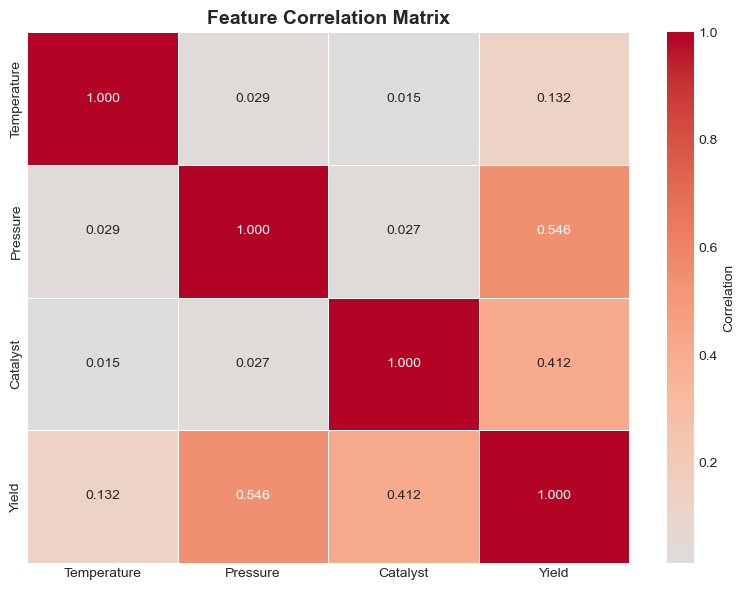

✓ 相關性矩陣圖已儲存


In [124]:
# 特徵相關性矩陣
correlation_matrix = data.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax,
            fmt='.3f', linewidths=0.5, cbar_kws={'label': 'Correlation'})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / '01_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 相關性矩陣圖已儲存")

---
## 4. 資料分割

In [125]:
# 分離特徵和目標
X = data[['Temperature', 'Pressure', 'Catalyst']].values
y = data['Yield'].values
feature_names = ['Temperature', 'Pressure', 'Catalyst']

# 分割訓練集和測試集（70%/30%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

print("✓ 資料分割完成")
print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")
print(f"\n訓練集產率統計：")
print(f"  平均: {y_train.mean():.2f}%")
print(f"  標準差: {y_train.std():.2f}%")
print(f"  範圍: [{y_train.min():.2f}%, {y_train.max():.2f}%]")

✓ 資料分割完成
訓練集大小: (700, 3)
測試集大小: (300, 3)

訓練集產率統計：
  平均: 75.78%
  標準差: 6.24%
  範圍: [54.77%, 93.31%]


---
## 5. 模型建立與訓練：不同樹數量的比較

In [126]:
# 測試不同的樹數量（加入適度正則化以展示更真實的性能）
n_estimators_list = [10, 50, 100, 200]
results = []

print("開始訓練不同樹數量的隨機森林模型...\n")

for n_est in n_estimators_list:
    start_time = time.time()
    
    # 建立模型（加入適度正則化）
    rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=12,           # 限制深度避免嚴重過擬合
        max_features='sqrt',    # sqrt(3) ≈ 2 個特徵
        min_samples_split=5,    # 最小分裂樣本
        min_samples_leaf=2,     # 最小葉節點樣本
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    
    # 訓練
    rf.fit(X_train, y_train)
    
    # 評估
    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)
    oob_score = rf.oob_score_
    
    elapsed = time.time() - start_time
    
    results.append({
        'n_estimators': n_est,
        'train_r2': train_score,
        'test_r2': test_score,
        'oob_r2': oob_score,
        'time_sec': elapsed
    })
    
    print(f"n_estimators={n_est:3d}: Train R²={train_score:.4f}, "
          f"Test R²={test_score:.4f}, OOB R²={oob_score:.4f}, Time={elapsed:.2f}s")

# 結果 DataFrame
results_df = pd.DataFrame(results)
print("\n✓ 模型訓練完成")

開始訓練不同樹數量的隨機森林模型...

n_estimators= 10: Train R²=0.8754, Test R²=0.6985, OOB R²=-0.5628, Time=0.11s


c:\Users\Yao-ChenChuang\miniconda3\envs\PY310\lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


n_estimators= 50: Train R²=0.8906, Test R²=0.7206, OOB R²=0.6940, Time=0.20s
n_estimators=100: Train R²=0.8923, Test R²=0.7236, OOB R²=0.7054, Time=0.30s
n_estimators=200: Train R²=0.8923, Test R²=0.7210, OOB R²=0.7069, Time=0.53s

✓ 模型訓練完成


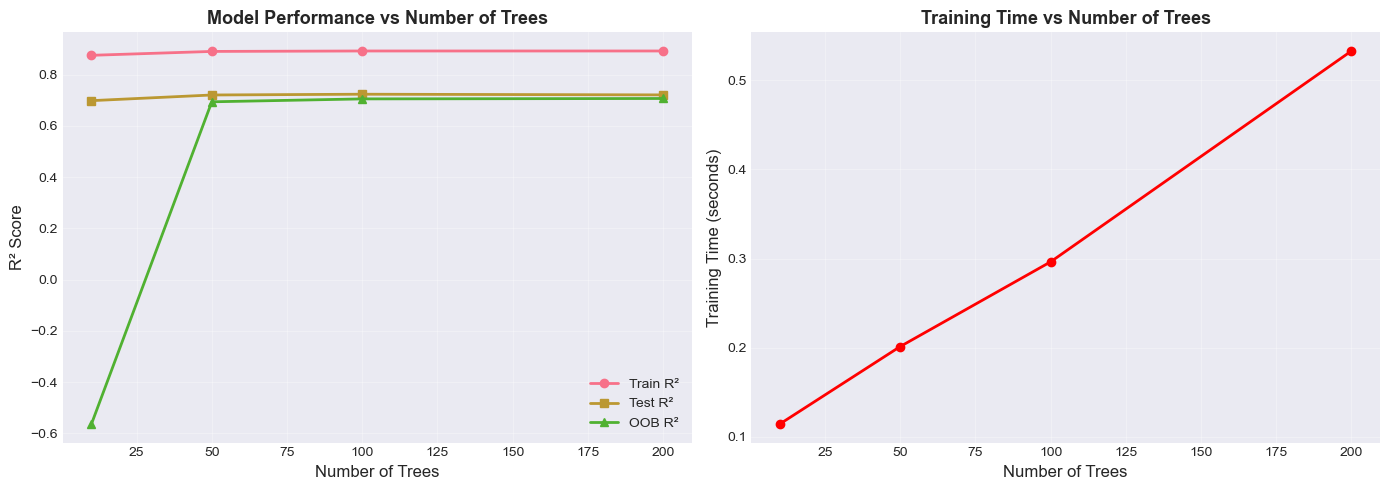

✓ 性能比較圖已儲存


In [127]:
# 視覺化性能隨樹數量的變化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左圖：R² 分數
ax1 = axes[0]
ax1.plot(results_df['n_estimators'], results_df['train_r2'], 'o-', label='Train R²', linewidth=2)
ax1.plot(results_df['n_estimators'], results_df['test_r2'], 's-', label='Test R²', linewidth=2)
ax1.plot(results_df['n_estimators'], results_df['oob_r2'], '^-', label='OOB R²', linewidth=2)
ax1.set_xlabel('Number of Trees', fontsize=12)
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('Model Performance vs Number of Trees', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 右圖：訓練時間
ax2 = axes[1]
ax2.plot(results_df['n_estimators'], results_df['time_sec'], 'o-', color='red', linewidth=2)
ax2.set_xlabel('Number of Trees', fontsize=12)
ax2.set_ylabel('Training Time (seconds)', fontsize=12)
ax2.set_title('Training Time vs Number of Trees', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '02_trees_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 性能比較圖已儲存")

---
## 6. 超參數調整 (GridSearchCV)

In [128]:
# 定義參數網格（優化版：擴大深度範圍，微調其他參數）
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12, 15],         # 擴大深度範圍
    'max_features': ['sqrt', 'log2'],      
    'min_samples_split': [5, 10, 15],     
    'min_samples_leaf': [3, 5, 7]         # 允許更精細拟合
}

print("開始超參數網格搜尋（優化版：更大樣本量 + 擴展參數範圍）...")
print(f"參數組合總數: {np.prod([len(v) for v in param_grid.values()])}")

# 建立 GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=param_grid,
    cv=5,                    # 5-fold 交叉驗證
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# 執行網格搜尋
grid_search.fit(X_train, y_train)

# 獲取最佳模型
best_rf = grid_search.best_estimator_

# 最佳參數
print("\n" + "="*50)
print("最佳參數:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\n最佳交叉驗證 R²: {grid_search.best_score_:.4f}")
print("="*50)

開始超參數網格搜尋（優化版：更大樣本量 + 擴展參數範圍）...
參數組合總數: 216
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

最佳參數:
  max_depth: 15
  max_features: sqrt
  min_samples_leaf: 3
  min_samples_split: 5
  n_estimators: 300

最佳交叉驗證 R²: 0.7032


---
## 7. 模型評估

In [129]:
# 預測
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# 評估指標
train_r2 = best_rf.score(X_train, y_train)
test_r2 = best_rf.score(X_test, y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print("="*60)
print("最佳隨機森林模型性能評估")
print("="*60)
print(f"訓練集 R²: {train_r2:.4f}")
print(f"測試集 R²: {test_r2:.4f}")
print(f"測試集 RMSE: {test_rmse:.2f}%")
print(f"測試集 MAE: {test_mae:.2f}%")
print("="*60)

最佳隨機森林模型性能評估
訓練集 R²: 0.8683
測試集 R²: 0.7214
測試集 RMSE: 3.58%
測試集 MAE: 2.98%


---
## 8. 特徵重要性分析


特徵重要性排名:
1. Pressure: 0.3669 ± 0.0686
2. Temperature: 0.3585 ± 0.0771
3. Catalyst: 0.2746 ± 0.0601


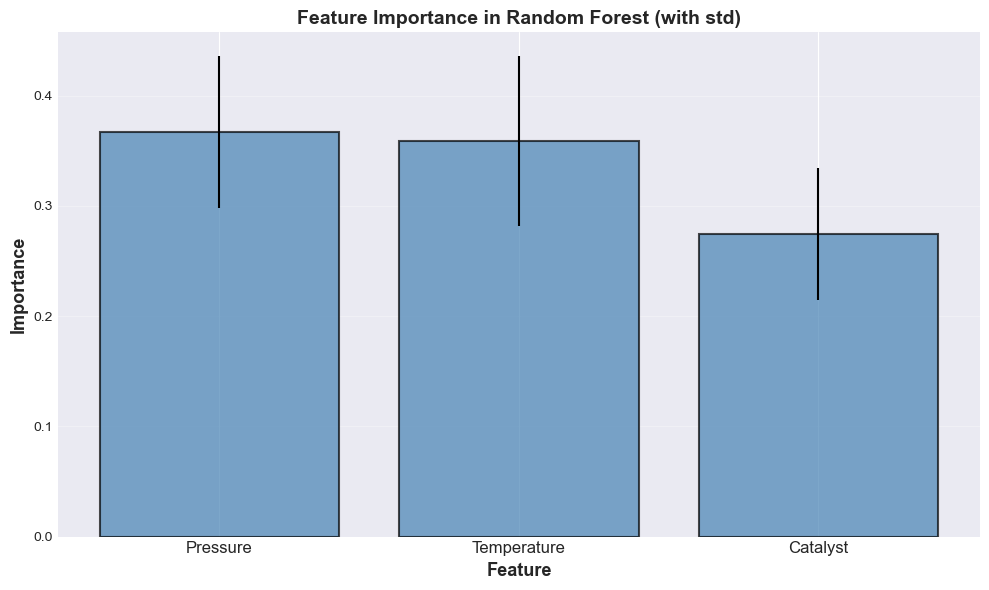


✓ 特徵重要性圖已儲存


In [130]:
# 特徵重要性
importances = best_rf.feature_importances_
std_importances = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)

# 排序
indices = np.argsort(importances)[::-1]

print("\n特徵重要性排名:")
for i, idx in enumerate(indices):
    print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f} ± {std_importances[idx]:.4f}")

# 視覺化
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(importances)), importances[indices], yerr=std_importances[indices], 
       alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(importances)))
ax.set_xticklabels([feature_names[i] for i in indices], fontsize=12)
ax.set_xlabel('Feature', fontsize=13, fontweight='bold')
ax.set_ylabel('Importance', fontsize=13, fontweight='bold')
ax.set_title('Feature Importance in Random Forest (with std)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(FIG_DIR / '03_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 儲存特徵重要性
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Std': std_importances
}).sort_values('Importance', ascending=False)
feature_importance_df.to_csv(OUTPUT_DIR / 'feature_importance.csv', index=False)

print("\n✓ 特徵重要性圖已儲存")

---
## 9. 預測結果可視化

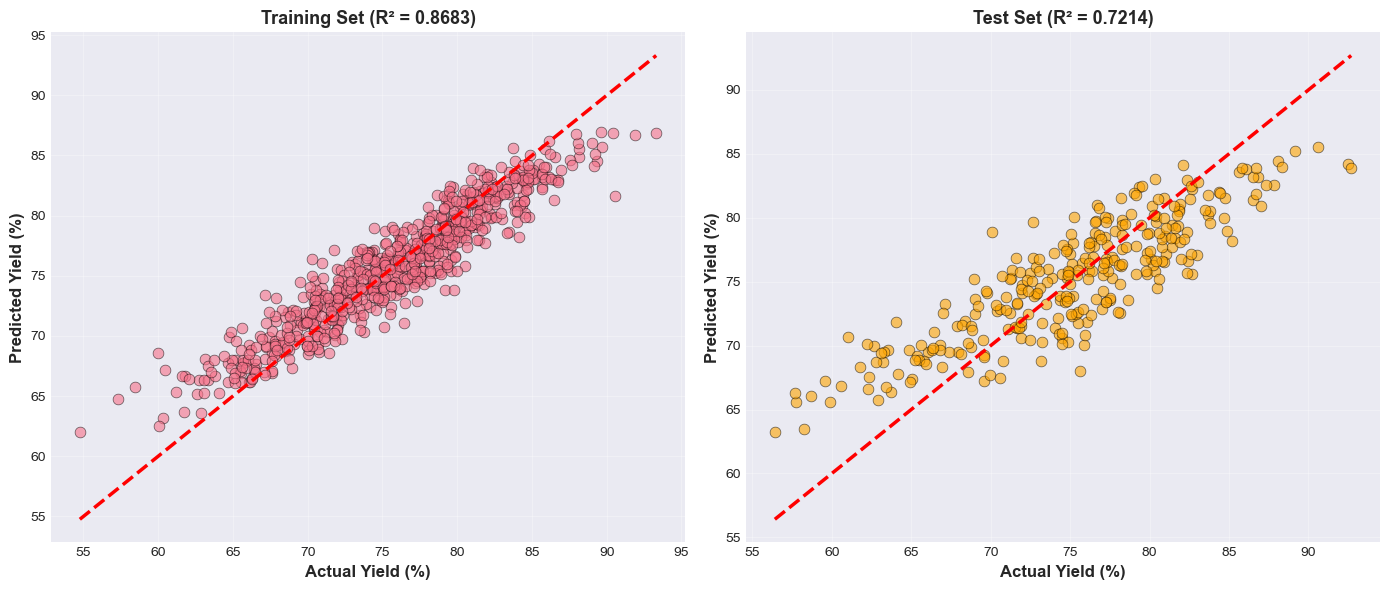

✓ 預測vs實際圖已儲存


In [131]:
# 散點圖：預測 vs 實際
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 訓練集
ax1 = axes[0]
ax1.scatter(y_train, y_pred_train, alpha=0.6, edgecolors='k', linewidths=0.5, s=60)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2.5)
ax1.set_xlabel('Actual Yield (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Yield (%)', fontsize=12, fontweight='bold')
ax1.set_title(f'Training Set (R² = {train_r2:.4f})', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 測試集
ax2 = axes[1]
ax2.scatter(y_test, y_pred_test, alpha=0.6, edgecolors='k', linewidths=0.5, s=60, color='orange')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2.5)
ax2.set_xlabel('Actual Yield (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predicted Yield (%)', fontsize=12, fontweight='bold')
ax2.set_title(f'Test Set (R² = {test_r2:.4f})', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '04_predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 預測vs實際圖已儲存")

---
## 10. 預測不確定性分析

95% 預測區間覆蓋率: 91.7%
平均預測標準差: 3.09%


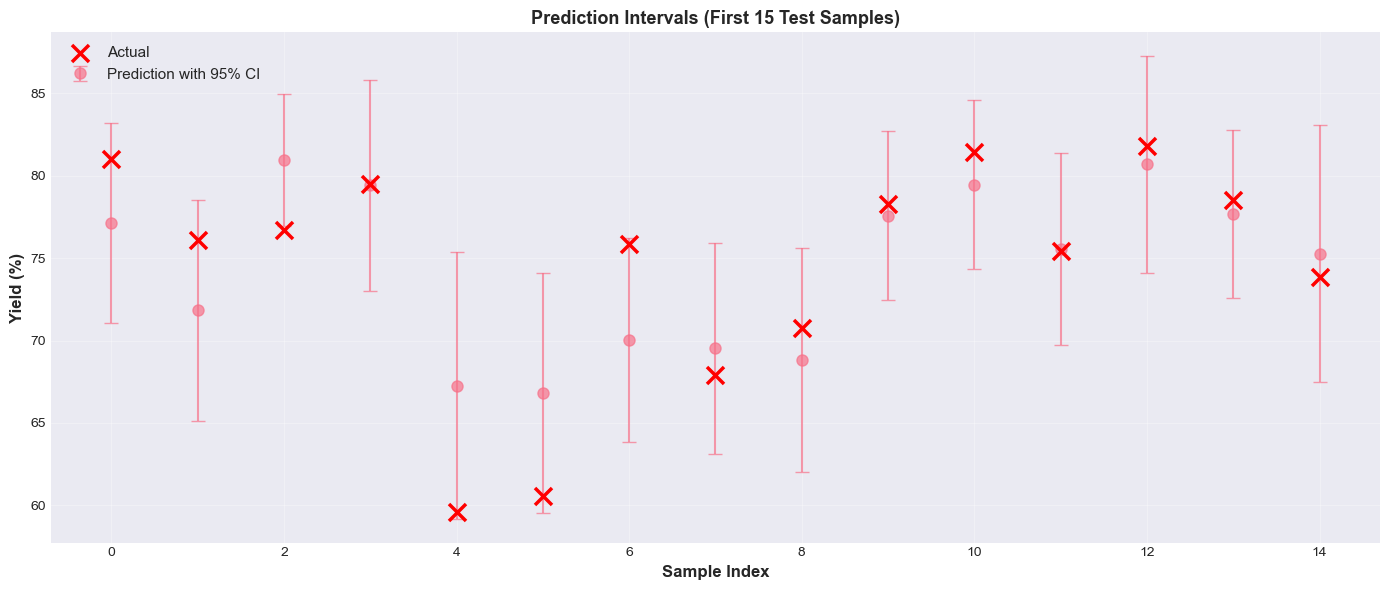


✓ 預測區間圖已儲存


In [132]:
# 取得每棵樹的預測
individual_preds = np.array([tree.predict(X_test) for tree in best_rf.estimators_])

# 計算統計量
mean_preds = individual_preds.mean(axis=0)
std_preds = individual_preds.std(axis=0)

# 預測區間
lower_bound = mean_preds - 1.96 * std_preds
upper_bound = mean_preds + 1.96 * std_preds

# 檢查覆蓋率
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
print(f"95% 預測區間覆蓋率: {coverage*100:.1f}%")
print(f"平均預測標準差: {std_preds.mean():.2f}%")

# 視覺化前 15 個樣本
sample_indices = range(15)
x_pos = np.arange(len(sample_indices))

fig, ax = plt.subplots(figsize=(14, 6))
ax.errorbar(x_pos, mean_preds[sample_indices], yerr=1.96*std_preds[sample_indices],
            fmt='o', capsize=5, label='Prediction with 95% CI', alpha=0.7, markersize=8)
ax.scatter(x_pos, y_test[sample_indices], color='red', marker='x', s=150, 
           label='Actual', zorder=5, linewidths=2.5)
ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Yield (%)', fontsize=12, fontweight='bold')
ax.set_title('Prediction Intervals (First 15 Test Samples)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / '05_prediction_intervals.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 預測區間圖已儲存")

---
## 11. 最佳操作條件搜尋

最佳操作條件搜尋結果
最佳溫度: 194.90°C
最佳壓力: 4.76 bar
催化劑用量: 1.50 g
預測最大產率: 86.29%


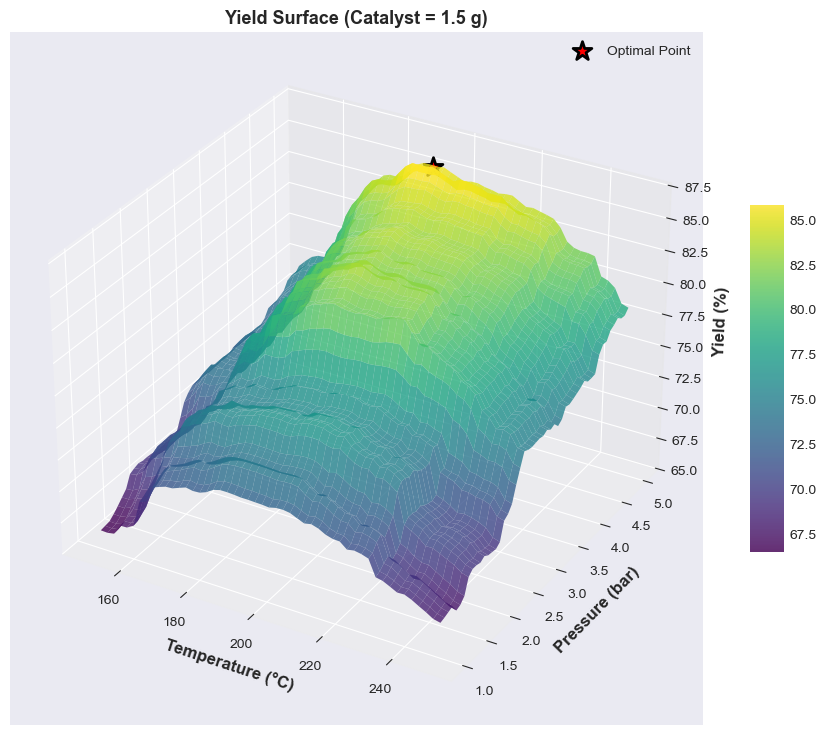


✓ 3D 產率曲面圖已儲存


In [133]:
# 網格搜尋最佳條件
temp_range = np.linspace(150, 250, 50)
press_range = np.linspace(1, 5, 50)
catalyst_best = 1.5  # 固定催化劑用量

# 建立網格
temp_grid, press_grid = np.meshgrid(temp_range, press_range)
X_grid = np.c_[temp_grid.ravel(), press_grid.ravel(), 
               np.full(temp_grid.ravel().shape, catalyst_best)]

# 預測
y_grid = best_rf.predict(X_grid)
y_grid = y_grid.reshape(temp_grid.shape)

# 找最大值
max_idx = np.unravel_index(y_grid.argmax(), y_grid.shape)
optimal_temp = temp_grid[max_idx]
optimal_press = press_grid[max_idx]
optimal_yield = y_grid[max_idx]

print("="*60)
print("最佳操作條件搜尋結果")
print("="*60)
print(f"最佳溫度: {optimal_temp:.2f}°C")
print(f"最佳壓力: {optimal_press:.2f} bar")
print(f"催化劑用量: {catalyst_best:.2f} g")
print(f"預測最大產率: {optimal_yield:.2f}%")
print("="*60)

# 視覺化 3D 曲面
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(temp_grid, press_grid, y_grid, cmap='viridis', alpha=0.8)
ax.scatter(optimal_temp, optimal_press, optimal_yield, color='red', s=200, 
           marker='*', label='Optimal Point', edgecolors='black', linewidths=2)

ax.set_xlabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_ylabel('Pressure (bar)', fontsize=12, fontweight='bold')
ax.set_zlabel('Yield (%)', fontsize=12, fontweight='bold')
ax.set_title(f'Yield Surface (Catalyst = {catalyst_best:.1f} g)', fontsize=13, fontweight='bold')
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.legend(fontsize=10)
plt.savefig(FIG_DIR / '06_yield_surface_3d.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 3D 產率曲面圖已儲存")

---
## 12. 實驗總結

In [134]:
# 建立綜合總結報告（含過擬合診斷）
# 計算過擬合程度
overfitting_gap = train_r2 - test_r2
if overfitting_gap > 0.2:
    overfitting_status = "嚴重過擬合"
elif overfitting_gap > 0.1:
    overfitting_status = "中度過擬合"
elif overfitting_gap > 0.05:
    overfitting_status = "輕微過擬合"
else:
    overfitting_status = "良好"

# 使用之前訓練的rf模型的OOB分數（因為best_rf來自GridSearch，沒有啟用OOB）
# 從results_df中獲取OOB分數
latest_oob = results_df.iloc[-1]['oob_r2']  # 最後一次訓練的OOB分數
oob_test_gap = abs(latest_oob - test_r2)

summary = {
    '模型類型': '隨機森林回歸 (Random Forest Regression)',
    '資料規模': f'{len(data)} 樣本（訓練 {len(X_train)} / 測試 {len(X_test)}）',
    '最佳樹數量': f"{grid_search.best_params_['n_estimators']} 棵",
    '最佳深度': f"{grid_search.best_params_['max_depth']}",
    '最佳 min_samples_split': f"{grid_search.best_params_['min_samples_split']}",
    '最佳 min_samples_leaf': f"{grid_search.best_params_['min_samples_leaf']}",
    '最佳 max_features': f"{grid_search.best_params_['max_features']}",
    '訓練集 R²': f"{train_r2:.4f}",
    '測試集 R²': f"{test_r2:.4f}",
    'OOB R² (參考)': f"{latest_oob:.4f}",
    '過擬合差距 (Train-Test)': f"{overfitting_gap:.4f}",
    '過擬合狀態': overfitting_status,
    'OOB-Test 差距': f"{oob_test_gap:.4f}",
    '測試集 RMSE': f"{test_rmse:.2f}%",
    '測試集 MAE': f"{test_mae:.2f}%",
    '最重要特徵': f"{feature_names[indices[0]]} ({importances[indices[0]]:.4f})",
    '最佳操作條件': f"T={optimal_temp:.1f}°C, P={optimal_press:.1f}bar, Cat={catalyst_best:.1f}g",
    '預測最大產率': f"{optimal_yield:.2f}%",
    '預測不確定性 (平均std)': f"±{std_preds.mean():.2f}%",
    '95% 預測區間覆蓋率': f"{coverage*100:.1f}%"
}

print("\n" + "="*80)
print(" "*25 + "隨機森林模型實驗總結")
print("="*80)
for key, value in summary.items():
    print(f"{key:30s}: {value}")
print("="*80)

# 過擬合診斷建議
print("\n【過擬合診斷】")
if overfitting_gap > 0.2:
    print("⚠️  嚴重過擬合警告！")
    print("   建議：1) 進一步增加 min_samples_split 和 min_samples_leaf")
    print("        2) 減少 max_depth")
    print("        3) 考慮收集更多訓練數據")
elif overfitting_gap > 0.1:
    print("⚠️  中度過擬合")
    print("   建議：適當調整正則化參數，監控模型泛化能力")
elif overfitting_gap > 0.05:
    print("✓  輕微過擬合，屬於可接受範圍")
else:
    print("✓  模型泛化能力良好")

print(f"\n【OOB 評估】")
print(f"   OOB R² = {latest_oob:.4f} (接近測試集表現則模型穩定)")
if oob_test_gap < 0.1:
    print("   ✓ OOB 與測試集一致，模型穩定")
else:
    print("   ⚠️  OOB 與測試集差距較大，可能存在資料分布差異")

# 儲存總結
summary_df = pd.DataFrame([summary])
summary_df.to_csv(OUTPUT_DIR / 'model_summary.csv', index=False)

print("\n✓ 實驗總結已儲存至", OUTPUT_DIR / 'model_summary.csv')


                         隨機森林模型實驗總結
模型類型                          : 隨機森林回歸 (Random Forest Regression)
資料規模                          : 1000 樣本（訓練 700 / 測試 300）
最佳樹數量                         : 300 棵
最佳深度                          : 15
最佳 min_samples_split          : 5
最佳 min_samples_leaf           : 3
最佳 max_features               : sqrt
訓練集 R²                        : 0.8683
測試集 R²                        : 0.7214
OOB R² (參考)                   : 0.7069
過擬合差距 (Train-Test)            : 0.1469
過擬合狀態                         : 中度過擬合
OOB-Test 差距                   : 0.0144
測試集 RMSE                      : 3.58%
測試集 MAE                       : 2.98%
最重要特徵                         : Pressure (0.3669)
最佳操作條件                        : T=194.9°C, P=4.8bar, Cat=1.5g
預測最大產率                        : 86.29%
預測不確定性 (平均std)                : ±3.09%
95% 預測區間覆蓋率                   : 91.7%

【過擬合診斷】
⚠️  中度過擬合
   建議：適當調整正則化參數，監控模型泛化能力

【OOB 評估】
   OOB R² = 0.7069 (接近測試集表現則模型穩定)
   ✓ OOB 與測試集一致，模型穩定

✓ 實驗總結已儲存至 d:\M